In [1]:
import os
import shutil
import unittest
from catvae.trainer import LightningCountVAE
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import argparse
import seaborn as sns

In [2]:
import torch
torch.__version__

'1.6.0'

# Simulate data

In [3]:
np.random.seed(0)
sims = multinomial_bioms(k=4, D=30, N=250, M=10000)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

In [4]:
sims['tree'].write('basis.nwk')

'basis.nwk'

# Train model

In [5]:
output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'train.biom',
    '--val-biom', 'train.biom',
    '--basis-file', 'basis.nwk',
    '--output-directory', output_dir,
    '--epochs', '3000',
    '--batch-size', '200',
    '--num-workers', '10',
    '--scheduler', 'cosine',
    '--learning-rate', '1e-2',
    '--n-latent', '4',
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
parser = LightningCountVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningCountVAE(args)
model.set_eigs(sims['eigvectors'], sims['eigs'])

trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=10,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type         | Params
---------------------------------------
0 | model | LinearCatVAE | 6 K   


Saving latest checkpoint..


1

In [6]:
%tb

No traceback available to show.


In [7]:
%load_ext tensorboard

In [8]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 24773), started 2:20:23 ago. (Use '!kill 24773' to kill it.)

In [9]:
trainer.model

LightningCountVAE(
  (model): LinearCatVAE(
    (encoder): Linear(in_features=29, out_features=4, bias=False)
    (decoder): Linear(in_features=4, out_features=29, bias=False)
  )
)

# Evaluate the model

In [20]:
!ls lightning_logs/version_2/checkpoints

'epoch=2999.ckpt'


In [21]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_2/checkpoints'
path = f'{checkpoint_dir}/epoch=2999.ckpt'
model = LightningCountVAE.load_from_checkpoint(path).cuda()

(0.9621273840895821, 3.696304277233197e-230)


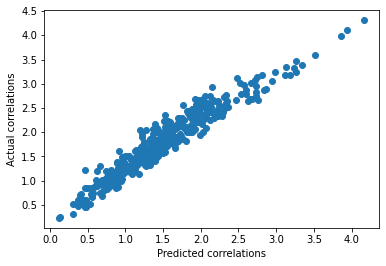

In [22]:
#W = model.model.get_loadings()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.model.decoder.weight.detach().cpu().numpy()

d_estW = pdist(W)
dW = pdist(sims['W'])
plt.scatter(dW * 2, d_estW)
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

In [23]:
Wu, Ws, Wv = np.linalg.svd(W)
k = W.shape[1]
Wu = Wu[:, :k]
Ws = Ws[:k]
Wv = Wv[:k, :]

In [28]:
W.T @ W

array([[ 3.5664558 ,  0.4634549 , -0.6194473 , -0.09068733],
       [ 0.4634549 , 18.727577  , -2.5310478 , -1.2280704 ],
       [-0.6194473 , -2.5310478 , 14.843038  ,  2.9676976 ],
       [-0.09068733, -1.2280704 ,  2.9676976 , 17.044037  ]],
      dtype=float32)

In [24]:
import torch
from catvae.dataset.biom import BiomDataset
from skbio.stats.composition import alr_inv, closure
valid_dataset = BiomDataset(valid)

In [15]:
decoder_np = model.model.decoder.weight.detach().cpu().numpy()
z = [] 
pred_z = []
pred_probs = []
counts = []
for i in range(len(valid_dataset)):
    cnts, batch_idx = valid_dataset[i]
    counts.append(closure(cnts))
    cnts = torch.Tensor(cnts).cuda().unsqueeze(0)
    res = model.forward(cnts)
    z.append(sims['z'][parts * 8 + i])
    pred_z.append(res['qz_m'].cpu().detach().numpy())
    pred_probs.append(alr_inv(res['px_mean'].cpu().detach().numpy()))

IndexError: too many indices for tensor of dimension 0

In [ ]:
counts = np.vstack(counts)
pred_probs = np.vstack(pred_probs)
pred_z = np.vstack(pred_z)

In [ ]:
from scipy.spatial.distance import pdist
d_predz = pdist(pred_z)
dz = pdist(z)

In [ ]:
z = np.vstack(z)

In [ ]:
sns.heatmap(pred_z)

In [ ]:
sns.heatmap(z)

In [ ]:
#W = model.model.get_loadings()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.model.decoder.weight.detach().cpu().numpy()

d_estW = pdist(W)
dW = pdist(sims['W'])
plt.scatter(dW, d_estW)
print(pearsonr(dW, d_estW))

In [ ]:
lam = np.ravel(sims['z'][parts * 8 : parts * 8 + 50] @ sims['W'].T)
pred_lam = np.ravel(z @ W.T)
plt.scatter(lam, pred_lam)
print(pearsonr(lam, pred_lam))

In [ ]:
z.shape, W.shape, lam.shape, sims['z'].shape, sims['W'].shape

In [ ]:
from scipy.stats import entropy
ens = []
for i in range(counts.shape[0]):
    e = entropy(counts[i], pred_probs[i])
    ens.append(e)

In [ ]:
sns.distplot(ens, bins=20)

In [ ]:
sns.heatmap(pred_probs)

In [ ]:
sns.heatmap(counts)

In [ ]:
plt.scatter(counts.ravel()+1, pred_probs.ravel()+1)
plt.xscale('log')
plt.yscale('log')

In [ ]:
pearsonr(counts.ravel()+1, pred_probs.ravel()+1)

In [ ]:
torch.exp(model.model.encoder.variational_logvars)

In [ ]:
parser

In [ ]:
# scratch work with least squares

from gneiss.balances import _balance_basis
from gneiss.cluster import random_linkage
d = 100
basis = _balance_basis(random_linkage(d))[0]

Id = np.eye(d)
dd = (1 / d) * np.ones((d, d))

A = Id - dd
b = np.random.randn(d)

x, err, rank, s = np.linalg.lstsq(A, b, rcond=None)